In [9]:
import  torch
from    deep_numerical.utils    import  *
from    itertools               import  product
import  matplotlib.pyplot       as      plt

from    deep_numerical.neuralop import  RadialFNO
from    deep_numerical.neuralop import  FNO
from    deep_numerical.utils    import  *
from    deep_numerical.numerical.distribution   import  maxwellian_homogeneous

In [10]:
B, Nx, Ny = 128, 64, 72

v_grid = velocity_grid(2, Nx, 5, dtype=torch.float)
rho = torch.tensor([[1.0]])
u = torch.tensor([[-1.0, 0.5]])
T = torch.tensor([[1.0]])
# X = (maxwellian_homogeneous(v_grid, rho, u, T).reshape(Nx, Nx) + 0.02) * v_grid.norm(p=2, dim=-1) + (v_grid[..., 0] * v_grid[..., 1]) / 300
X = torch.rand((Nx, Nx))

X = X[:, :, None]
X = torch.stack(
    [torch.rot90(X, n, dims=(0,1)) for n in range(4)],
    dim = 0,
)
X = torch.cat(
    [X, X.flip(dims=(1,))],
    dim = 0,
)
print(X.shape)
n_modes = 11

model = FNO(
    n_modes = (n_modes, n_modes),
    in_channels     = 1,
    out_channels    = 1,
    hidden_channels = 32,
    n_layers = 2,
    pos_enc = False,
)
initialize_weights(model, init_name='xavier normal')
print(f"Number of parameters: {model.count_parameters():.2e}")

torch.Size([8, 64, 64, 1])
Number of parameters: 2.90e+05


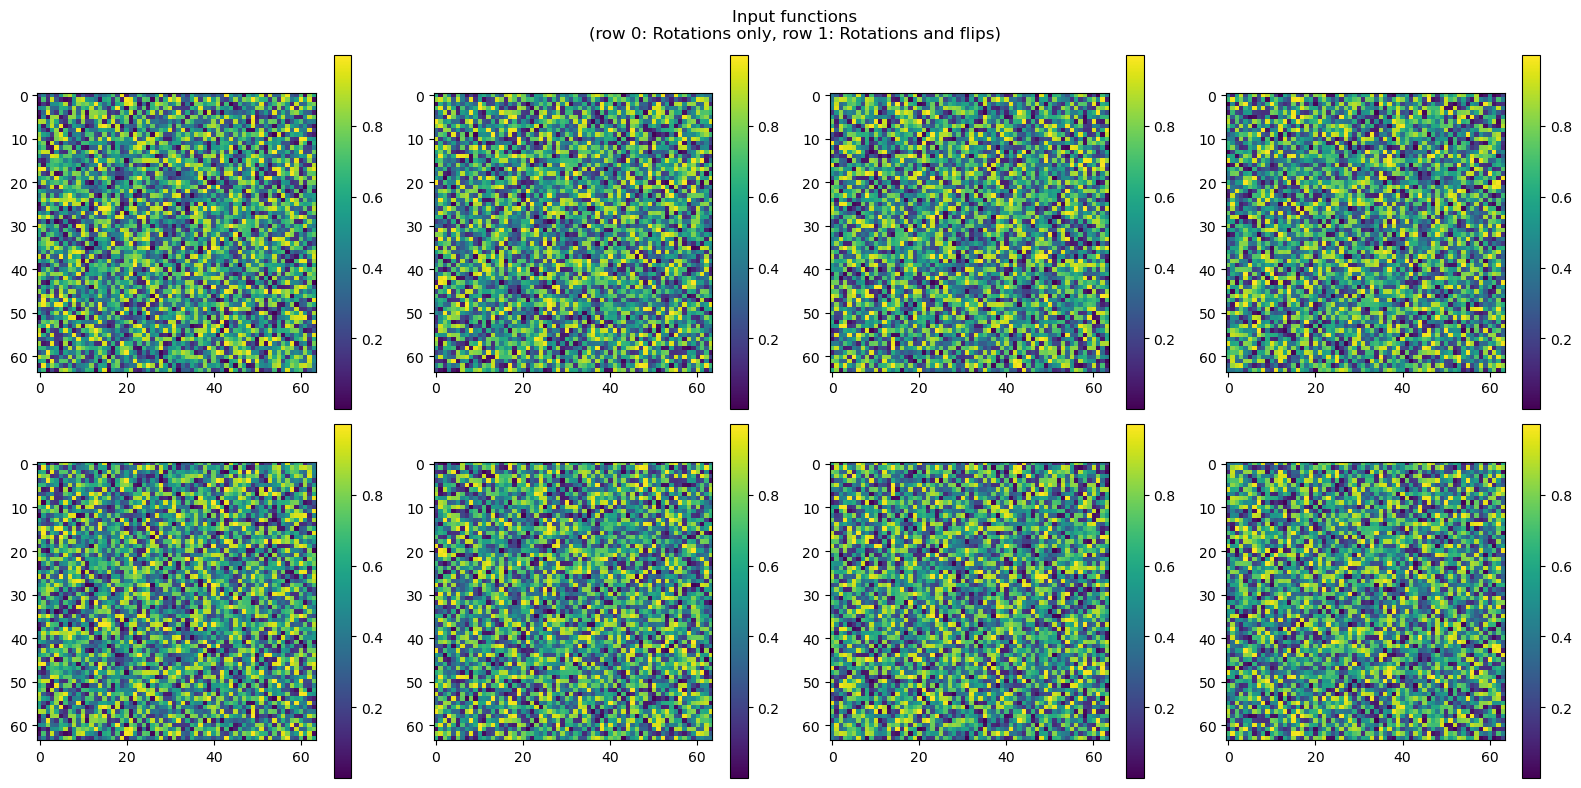

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Input functions\n(row 0: Rotations only, row 1: Rotations and flips)")

for x_idx, (r, c) in enumerate(product(range(2), range(4))):
    fig.colorbar(axes[r, c].imshow(X[x_idx, ..., 0]))
    
fig.tight_layout()
fig.show()

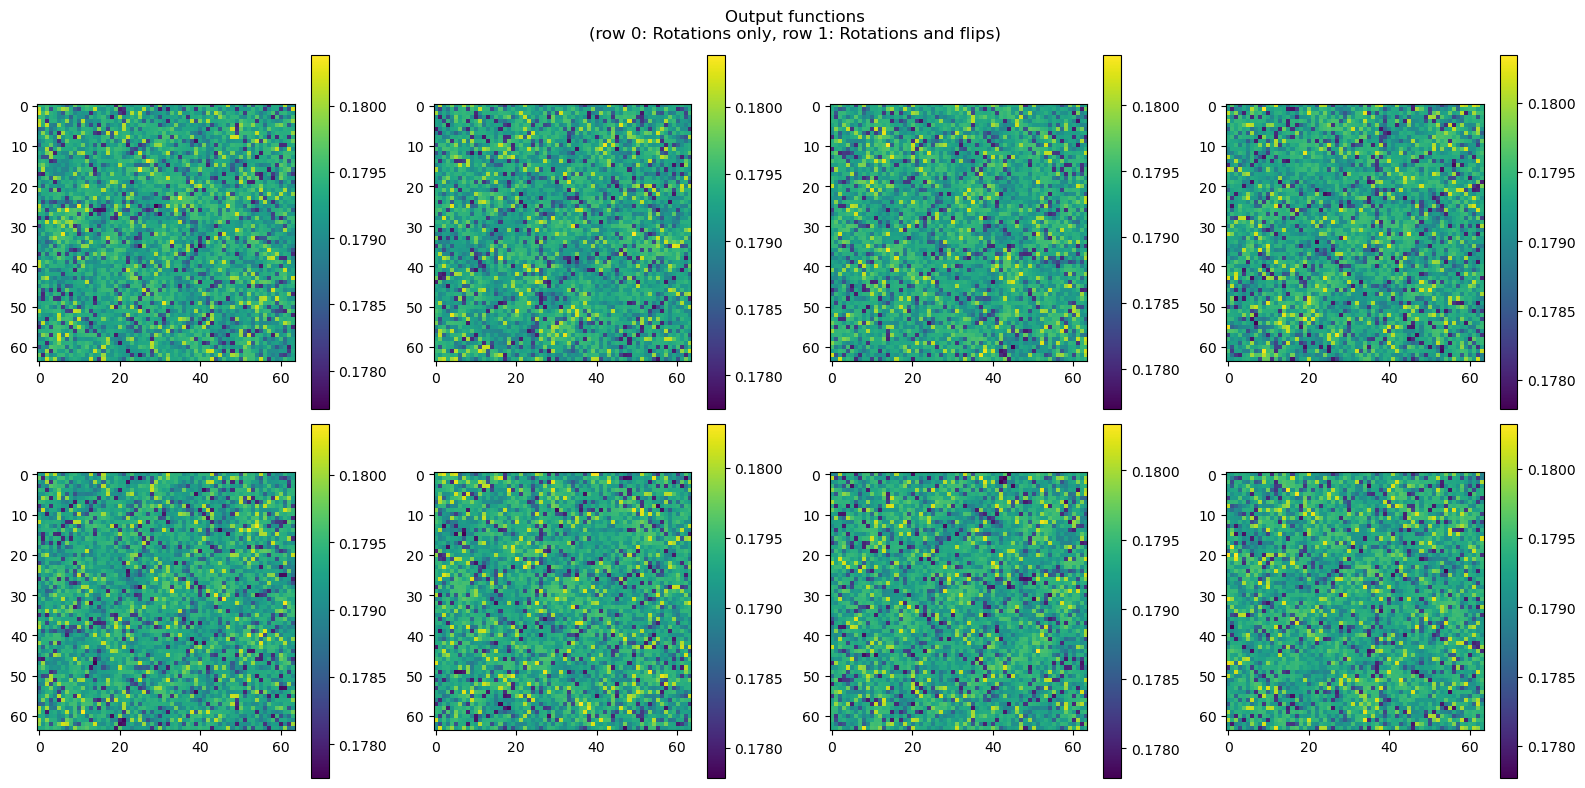

In [12]:
with torch.inference_mode():
    Y = model.forward(X)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Output functions\n(row 0: Rotations only, row 1: Rotations and flips)")

for x_idx, (r, c) in enumerate(product(range(2), range(4))):
    fig.colorbar(axes[r, c].imshow(Y[x_idx, ..., 0]))

fig.tight_layout()
fig.show()

In [13]:
Z = Y[0]
Z = torch.stack(
    [torch.rot90(Z, n, dims=(0,1)) for n in range(4)],
    dim = 0,
)
Z = torch.cat(
    [Z, Z.flip(dims=(1,))],
    dim = 0,
)

In [14]:
max_diff = (Y - Z).norm(p=torch.inf).item()
print(f"Maximum difference: {max_diff:.4e}")

p = 1
rel_error = relative_error(Z, Y, p=p)
print(f"Relative error ({p=}): {rel_error.mean():.4e} +/- {rel_error.std():.4e}")

Maximum difference: 4.8545e-04
Relative error (p=1): 4.8525e-04 +/- 2.0015e-04


In [15]:
%%timeit -n 25 -r 3
with torch.inference_mode():
    Y = model.forward(X)

24.1 ms ± 462 μs per loop (mean ± std. dev. of 3 runs, 25 loops each)


In [16]:
# [
#     torch.sin(torch.linspace(0, 1, d) * 2*torch.pi)
#     for d in (16, 32)
# ] + [
#     torch.cos(torch.linspace(0, 1, d) * 2*torch.pi)
#     for d in (16, 32)
# ]
v = space_grid(2, (Nx, Ny), torch.pi)
print(v.shape)

temp = []
for d in range(v.size(-1)):
    temp.append(v[..., d].sin())
    temp.append(v[..., d].cos())
temp = torch.stack(temp, dim=-1)
print(temp.shape)
print(temp[..., 0].min(), temp[..., 1].max())

torch.Size([64, 72, 2])
torch.Size([64, 72, 4])
tensor(-0.9988, dtype=torch.float64) tensor(0.9988, dtype=torch.float64)


End of file